# Movie Analysis by Genre

Chau Nguyen and Brad Johnson<br />
Flatiron School-DC Data Science 100719 Cohort<br />
Module 1 Project 1

# Table of Contents
1. [Clean data](#clean-data)
1. [Break out individual genres](#break-out-genres)


Import standard libraries:

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import custom libraries:

In [560]:
import movie_data as md
import split_data_fields as sdf
import movie_charts as mc

Set plotting options:

In [538]:
sns.set_context('poster')
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_style('whitegrid')

## Import and clean data <a class="anchor" id="clean-data"></a>

Tables of interest:
* `imdb.title.basics`  (for genres)
* `imdb.title.ratings` (for average ratings)
* `tn.movie_budgets` (for budgets and worldwide gross)

`md.generate_movie_analysis_df()` uses functions from the custom `data_cleaning` library.

Data attributes and data-cleaning settings are stored in the `TABLE_FORMATS` dict in `data_cleaning`.

* **Importing**: function `df_from_movie_csv` loads csv.gz by tablename into dataframe, setting index, converting date fields to date time, converting dollar fields to numeric.
* **Cleaning**: function `clean_movie_df` standardizes field names, adds a `year` column if appropriate, filters results to 2010-2018, and normalizes dollar fields to millions.
* **Deduping**: function `select_max_rows_on_key_column` picks the entries by `title` with max `numvotes`
* **Merging**: function `join_dfs_on_key_col` joins the dataframes on `title`
* **Calculating**:
 * `profit` = `worldwide_gross` - `production_budget`
 * `roi` = `profit` / `production_budget`



In [539]:
df = md.generate_movie_analysis_df()

Importing tables into dataframes...
Cleaning data...
Merging IMDB data...
Deduping IMDB data...
Merging TheNumbers data...
Calculating profit and ROI


In [541]:
df.to_csv('movie_data.csv.gz')

### Table: Summary of our movie dataset

In [542]:
df.describe()

,start_year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,year,profit,roi
count,1750.000000,1743.000000,1742.000000,1.742000e+03,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,2013.632000,106.172691,6.262801,1.040751e+05,38.226549,47.611831,119.641575,2013.788000,81.415025,2.392184
std,2.405089,17.759023,1.069533,1.568357e+05,52.648305,79.954285,219.173274,2.383998,179.751048,11.494607
min,2010.000000,12.000000,1.600000,6.000000e+00,0.001400,0.000000,0.000000,2010.000000,-110.450242,-1.000000
25%,2012.000000,94.000000,5.700000,9.116500e+03,4.712500,0.351123,1.860575,2012.000000,-1.399592,-0.697032
50%,2014.000000,104.000000,6.400000,4.726050e+04,18.000000,17.734367,34.951873,2014.000000,12.667179,0.727687
75%,2015.000000,116.000000,7.000000,1.240532e+05,45.000000,56.974742,126.874641,2016.000000,78.714168,2.644018
max,2019.000000,180.000000,8.800000,1.841066e+06,410.600000,700.059566,2048.134200,2018.000000,1748.134200,415.564740


There are 1750 movies from 2010-2018 in the clean dataset. `production_budget`, `domestic_gross`, `worldwide_gross`
and `profit` are in millions of dollars. `roi` is dimensionless.

### Plot: Variable correlation measures for various attributes

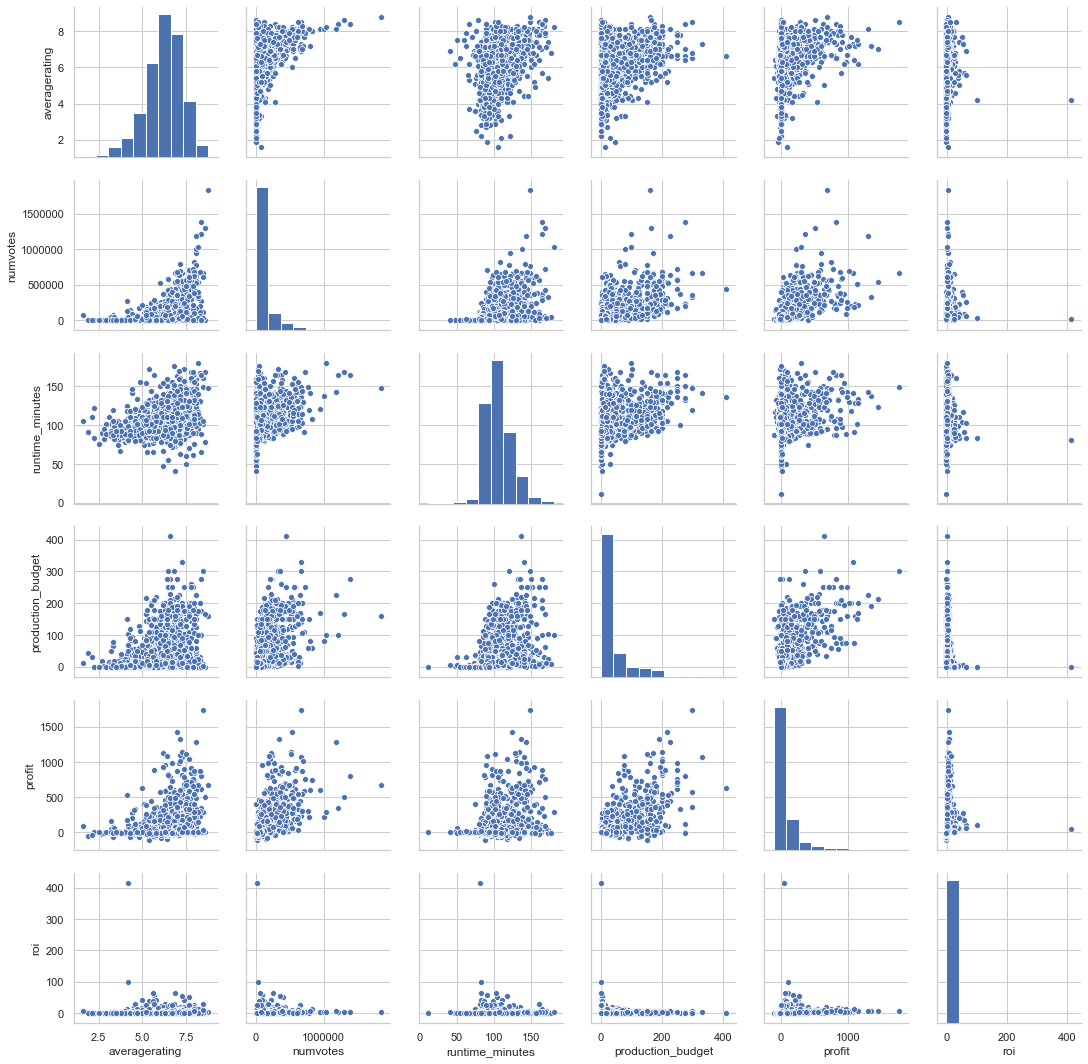

In [558]:
sns.pairplot(df[['averagerating', 'numvotes', 'runtime_minutes', 'production_budget','profit', 'roi']]);

## Break out individual genres <a class="anchor" id="break-out-genres"></a>

Multiple genres are assigned to a given title in the dataset (e.g. `action,adventure,animation`). 

To analyze genres independently, we generate a new dataframe with a distinct row for each genre per title using the custom `split_data_fields` (`sdf`) library.

Function `sdf.multifield_to_col` returns a dataframe containing multiple rows for a given title, one for each genre in its genres list.

In [543]:
expand_df = sdf.multifield_to_col(df, 'tconst', 'genres')

In [544]:
expand_df.to_csv('movie_data_genre_breakout.csv.gz')

We first conducted an analysis of the dataset looking at all genres. 

### Table: Count of movies associated with an individual genre

In [548]:
pd.DataFrame(expand_df.genre.value_counts())

,genre
Drama,886
Comedy,591
Action,489
Adventure,375
Thriller,313
Crime,281
Romance,225
Horror,222
Sci-Fi,157
Biography,152


### Plot: Count of movies associated with an individual genre

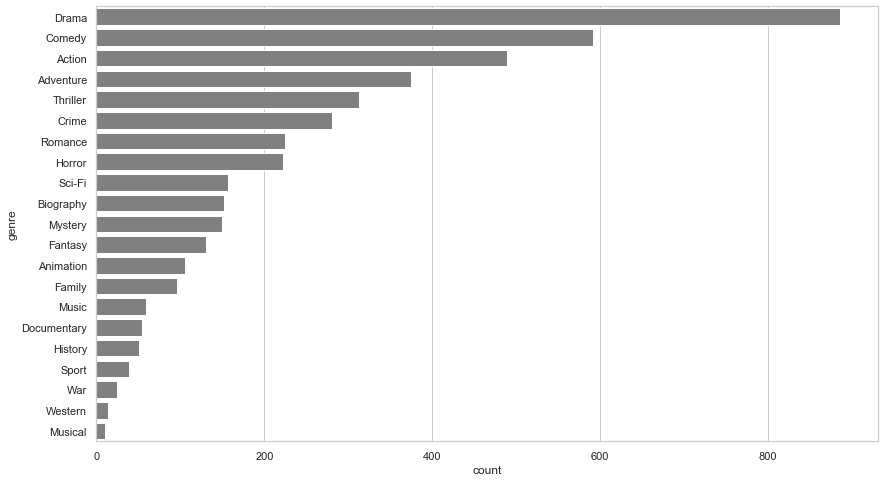

In [545]:
sns.countplot(y='genre',data=expand_df,
              order=full_expand_df.genre.value_counts().index,
              color="grey");

For our final presentation, we decided to explore the genres that were most commonly produced in order to narrow our analysis. 

We chose a minimum of 100 movies per genre as our cut-off.

## Filter genres to those associated with over 100 movies

`dc.filter_df_by_field_count(expand_df, 'genre', 100)` returns new dataframe filtered for the category `genre` with at least 100 records per `genre`.

In [551]:
filtered_df = dc.filter_df_by_field_count(expand_df, 'genre', 100)

Save a copy of our original, full dataset.

In [552]:
full_expand_df = expand_df.copy()
expand_df = filtered_df

This results in a set of 13 distinct genres. How many movies remain?

### Plot: Count of movies associated with an individual genre (filtered)

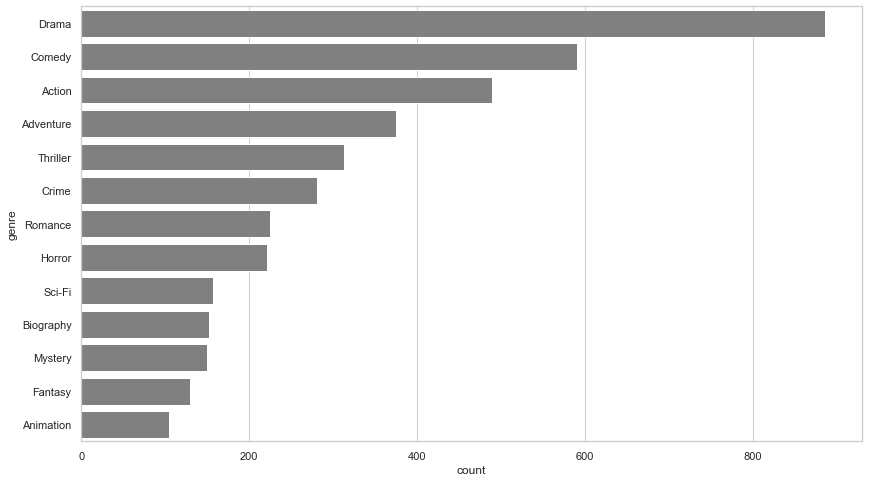

In [554]:
sns.countplot(y='genre', data=expand_df,
              order=expand_df.genre.value_counts().index,
              color="grey");

## Data Analysis

Investigating the financial measures by genre to determine which genres are most successful. We are interested in the following questions:
* Which types of movies are most profitable?
* What movies give the best return on investment?
* What movies give the most reliable profits and ROI?
* What movies have potentially large risk (losses) or large upside?
* Is there a relationship between movie quality and financial success?

Because we are interested in reliability, risk, and upside, we use box plots to display distribution.

We also use scatterplots to explore the distribution of our data.



### Genre vs. worldwide gross

Animation, adventure, action, sci-fi, and fantasy (which we found in our multi-genre exploration are often associated with each other) generate the highest box-office revenue.

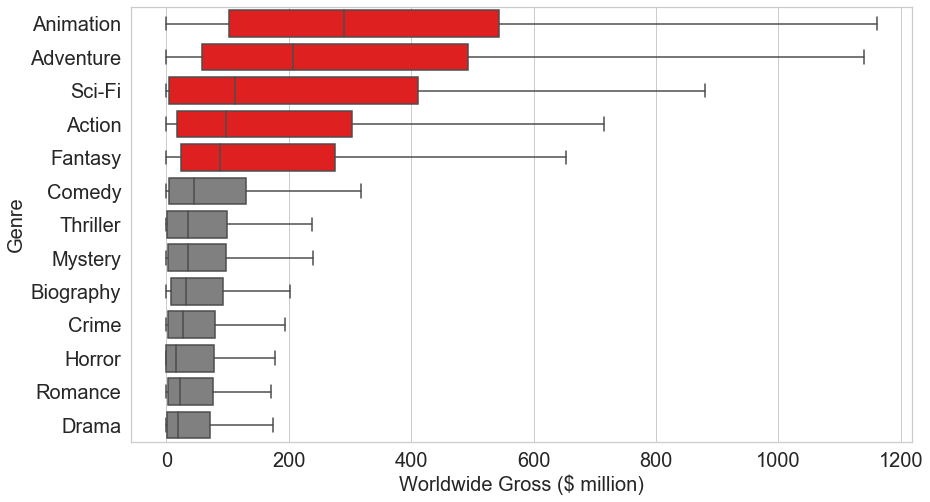

In [509]:
mc.make_genre_boxplot(expand_df,'worldwide_gross',value_num=13,
                   highlight_list=['Action', 'Adventure', 'Sci-Fi', 'Animation', 'Fantasy'],
                   xlabel='Worldwide Gross ($ million)',
                   ylabel='Genre');

### Genre vs. budget

The same films are the most expensive to produce.

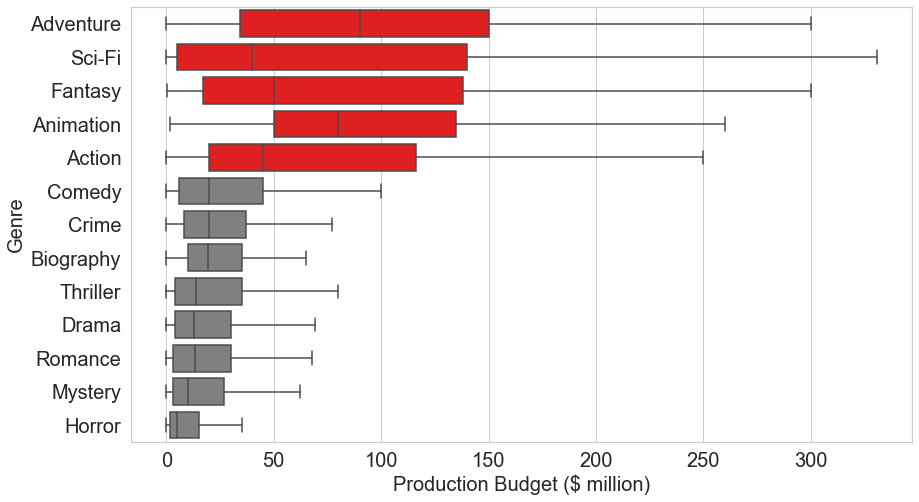

In [494]:
mc.make_genre_boxplot(expand_df,'production_budget',value_num=13,
                   highlight_list=['Action','Adventure','Sci-Fi','Animation','Fantasy'],
                   xlabel='Production Budget ($ million)',
                   ylabel='Genre');

### Genre vs. profit

Despite being the most expensive to produce, they are the most profitable. They also have the largest potential for losses. Note that `drama` is the lowest-profit genre yet also has high risk of significant loss.

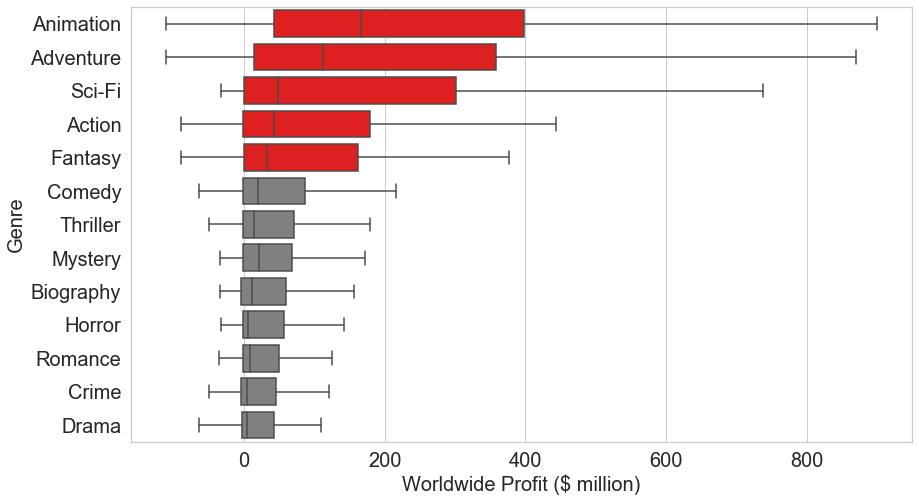

In [562]:
mc.make_genre_boxplot(expand_df,'profit',value_num=13,
                      highlight_list=['Action', 'Adventure', 'Sci-Fi', 'Animation', 'Fantasy'],
                   	  xlabel='Worldwide Profit ($ million)',
                      ylabel='Genre');

### Genre vs. ROI

ROI is is an indicator of profit relative to cost. It is a good measure for low-budget success.

Mystery and horror are the top-performing genres for ROI. The upside potential for both is very high. Drama and crime films are worst-performing.

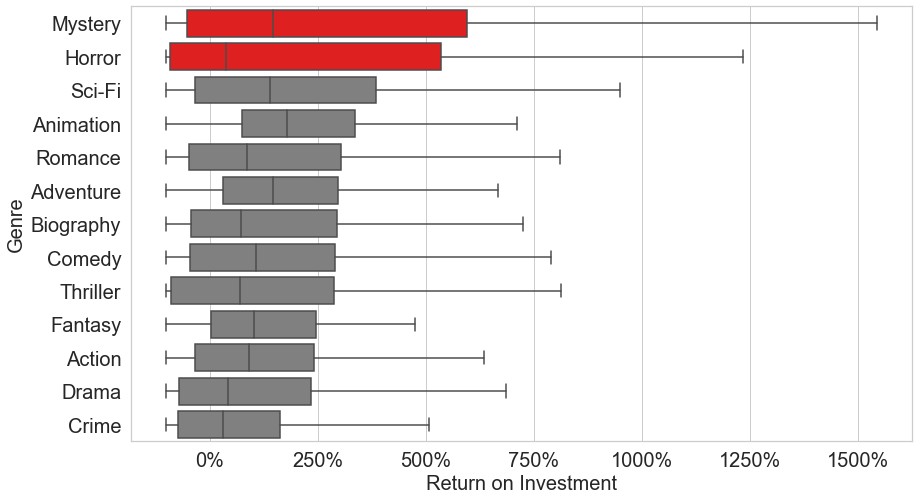

In [563]:
mc.make_genre_boxplot(expand_df,'roi',value_num=13,
                   highlight_list=['Horror', 'Mystery'],
                   xlabel='Return on Investment',
                   ylabel='Genre',
                   formatx_as_percent=True);

### ROI scatterplot: profit vs budget colored by genre

Another way to explore ROI is with a scatterplot of profit vs. budget. We decided to look at movies tagged with the genre 'horror' vs. all others.

In [565]:
expand_df['horror'] = np.where(expand_df['genre']=='Horror', 'Horror', 'Not Horror')

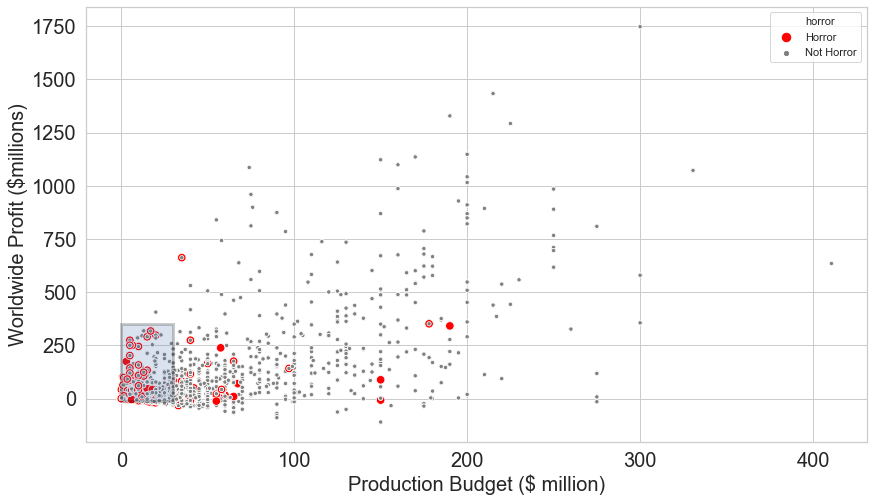

In [566]:
import matplotlib.patches as patches
sns.set(rc={'figure.figsize':(14,8)})
sns.set_style('whitegrid')

genre_list = expand_df.groupby('genre').max().sort_values(ascending=False, 
                                                   by='roi')[:13].index.to_list()
palette = ['gray']*10
palette[0]='red'
splot = sns.scatterplot(data=expand_df[expand_df['genre'].isin(genre_list)],
                        x='production_budget',
                        y='profit',
                        hue='horror',
                        size='horror',
                        palette=['red','gray'],
                        hue_order=['Horror', 'Not Horror'],
                        size_order=['Horror', 'Not Horror'])
splot.set_xlabel("Production Budget ($ million)",fontsize=20)
splot.set_ylabel("Worldwide Profit ($millions)",fontsize=20)
splot.tick_params(labelsize=20)
splot.add_patch(patches.Rectangle((0, -10), # (x,y)
                                    30, # width
                                    360, # height
                                    alpha=0.2, 
                                    facecolor="blue",
                                    edgecolor="black", 
                                    linewidth=3,
                                    linestyle='solid'));


## Exploring ratings

Do "higher-quality" movies provide a better ROI? We use the IMDB average user rating as a proxy for quality.

### Scatterplot: ROI vs. Average rating

As above, we look deeper into horror. 

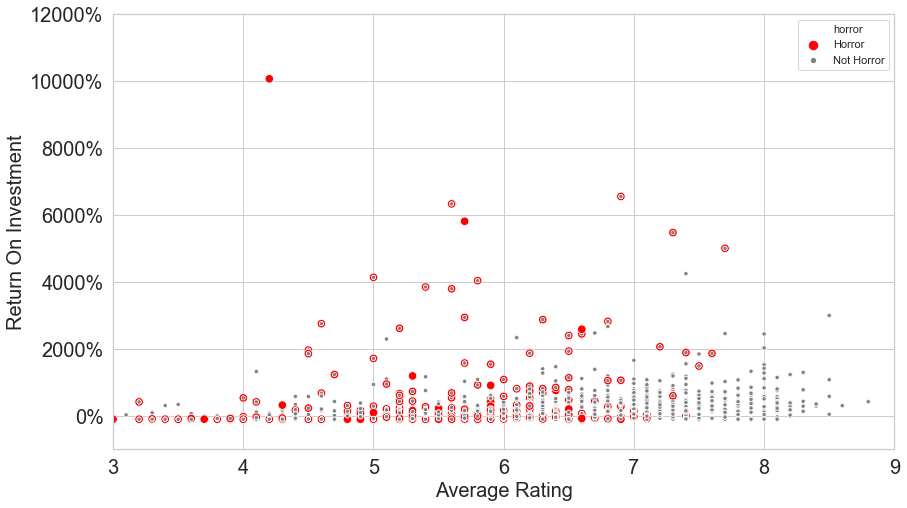

In [460]:
genre_list = expand_df.groupby('genre').max().sort_values(ascending=False, 
                                                   by='roi')[:13].index.to_list()
palette = ['gray']*10
palette[0]='red'
splot = sns.scatterplot(data=expand_df[expand_df['genre'].isin(genre_list)],
                        x='averagerating',
                        y='roi',
                        hue='horror',
                        size='horror',
                        palette=['red','gray'],
                        hue_order=['Horror', 'Not Horror'],
                        size_order=['Horror', 'Not Horror'])
splot.set_xlabel("Average Rating",fontsize=20)
splot.set_ylabel("Return On Investment",fontsize=20)
splot.tick_params(labelsize=20)
plt.xlim(3,9)
plt.ylim(-10,120)
splot.set_yticklabels(['{0:.0%}'.format(x) for x in splot.get_yticks()]);

The above chart shows:
* there is not a high ROI for movies with an average rating of 4 or below
* Almost every movie with an ROI > 20 is a horror (or multi-genre horror) movie
* No movies rated 8 or above are horror movies 
* This also means that very few movies rated 8 or above have a high ROI

Implied conclusions: 
* A movie doesn't have to be superlative to be financially successful
* Horror movies don't even have to be particularly good to be very financially successful

## Actionable Insights

1. Avoid drama if your goal is any of: high profits, ROI, or low risk of loss
1. For high profits, big-budget action/adventure/animation (with SF/fantasy) are best
1. For high ROI, low-budget mystery/horror are best performing
1. A movie doesn't have to be superlative to be financially successful
1. Horror movies don't even have to be particularly good to be very financially successful


## Supplementary analysis

### Top movies

In [516]:
# by genre movie with max profit

top_list = expand_df.reset_index().groupby('genre').max()['profit'].reset_index()

expand_df[]

,genre,profit
0,Action,1748.134200
1,Adventure,1748.134200
2,Animation,1122.469910
3,Biography,839.985342
4,Comedy,1122.469910
5,Crime,1328.722794
6,Drama,839.985342
7,Fantasy,1099.199706
8,Horror,662.457969
9,Mystery,506.464305


In [525]:
expand_df[expand_df.groupby('genre')['profit'].transform(max) == expand_df['profit']].sort_values('profit',ascending=False)

,title,original_title,start_year,runtime_minutes,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,year,profit,roi,genre
tconst,,,,,,,,,,,,,,
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Action
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Adventure
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Sci-Fi
tt2820852,Furious 7,Furious Seven,2015,137.0,7.2,335074.0,2015-04-03,190.0,353.007020,1518.722794,2015,1328.722794,6.993278,Crime
tt2820852,Furious 7,Furious Seven,2015,137.0,7.2,335074.0,2015-04-03,190.0,353.007020,1518.722794,2015,1328.722794,6.993278,Thriller
tt2294629,Frozen,Frozen,2013,102.0,7.5,516998.0,2013-11-22,150.0,400.738009,1272.469910,2013,1122.469910,7.483133,Animation
tt2294629,Frozen,Frozen,2013,102.0,7.5,516998.0,2013-11-22,150.0,400.738009,1272.469910,2013,1122.469910,7.483133,Comedy
tt2771200,Beauty and the Beast,Beauty and the Beast,2017,129.0,7.2,238325.0,2017-03-17,160.0,504.014165,1259.199706,2017,1099.199706,6.869998,Fantasy
tt1727824,Bohemian Rhapsody,Bohemian Rhapsody,2018,134.0,8.0,345466.0,2018-11-02,55.0,216.303339,894.985342,2018,839.985342,15.272461,Biography


# Looking at genre combinations

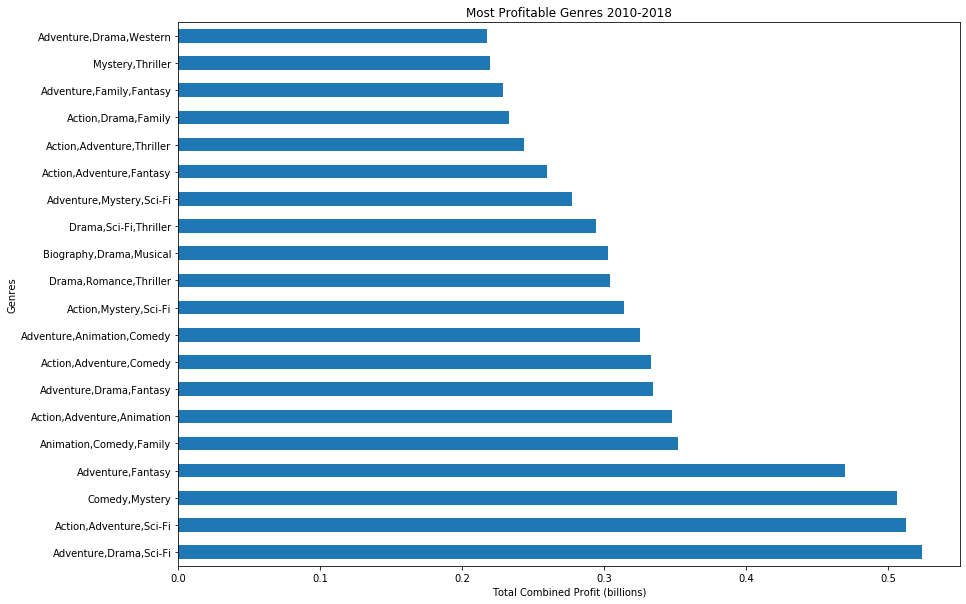

In [15]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').sum().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].div(1000).plot.barh()

ax.set_xlabel('Total Combined Profit (billions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');


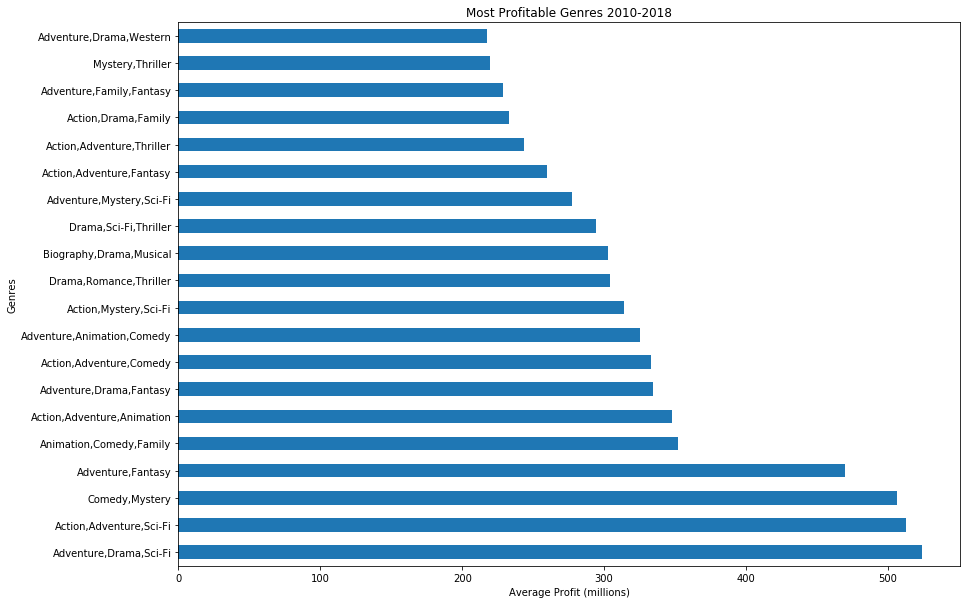

In [16]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].plot.barh()

ax.set_xlabel('Average Profit (millions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');

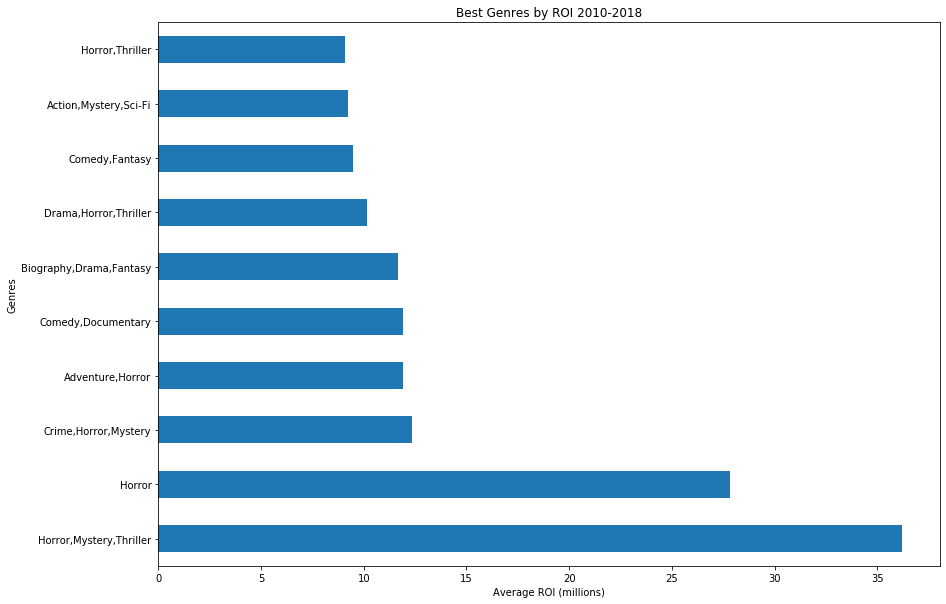

In [18]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='roi')['roi'][:10].plot.barh()

ax.set_xlabel('Average ROI (millions)')
ax.set_ylabel('Genres')
ax.set_title('Best Genres by ROI 2010-2018');